# A3_Create_and_Test_Model

This workbook **creates** and **test** the model. 

This entails the following steps:

| No.     | Step                                          |
| :-------| :---------------------------------------------|
| A3.1    | Import Libraries                              |
| A3.2    | Load Images                                   |
| A3.3    | Split Into Train and Test                     |
| A3.4    | Create Model                                  |
| A3.5    | Test Model                                    |

## A3.1 Import Libraries

In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2lab, deltaE_cie76
import cv2
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
import h5py

## A3.2 Load Images

In [ ]:
#Load images
data_dir = '../deepfashionextract3/img/'
categories = ['top', 'skirt', 'dress']

data = []

def create_data():
    
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)

        for filename in os.listdir(path):
            #Load image
            img_data = os.path.join(path, filename)
            image = cv2.imread(img_data)
            
            try:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                #Minimize to approx. one third
                image = cv2.resize(image, (96,96))
                image = np.array(image, dtype=np.float32)
                
                data.append([image, label])
            
            except Exception as e:
                pass
            
    print(len(data))
    
    #wb for write and binary
    pick = open('a_data.pickle', 'wb')
    pickle.dump(data, pick)
    pick.close()

In [ ]:
create_data()

In [ ]:
def load_data():
    #rb for read and binary
    pick = open('a_data.pickle', 'rb')
    data = pickle.load(pick)
    pick.close()
    
    #Shuffle the data
    np.random.shuffle(data)
    
    feature = []
    labels = []
    
    for img, label in data:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype=np.float32 )
    labels = np.array(labels)
        
    ##Normalize the pixels between 0 and 1
    feature = feature/255.0
    
    return [feature, labels]

In [ ]:
load_data()

## A3.3 Split Into Train and Test

Since we do not have a large dataset only **10%** is saved for **test** so that more data can be used for training. 

In [ ]:
#Unpack feature and labels
(feature, labels) = load_data()

In [ ]:
#Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.1)

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% Count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.style.use('fivethirtyeight')
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    labels = ['Top', 'Skirt', 'Dress']
    plt.xticks(xtemp, labels)
    plt.ylabel(ylabel_text)
    plt.suptitle('Images per Category')
    
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'Train: ({0} images)'.format(len(y_train)),
    'Test: ({0} images)'.format(len(y_test)), 
], loc=10);

## A3.4 Create Model

The model is created with **6 convolutional and pool layers and pools** to which the input sequentially passes.

Adjusting the hyperparameters, the following has proven to achieve an optimal result with the data at hand:

| No. | Findings                                                                         |
|:----|:---------------------------------------------------------------------------------|
| 1.  | 6 convolutional and pool layers rather than smaller and higher numbers of layers |
| 2.  | 96 filters rather than a mix of 32, 64 and 96 filters                            |
| 3.  | 512 neurons rather than 128 neurons                                              |
| 4.  | Adding a dropout layer                                                           |
| 5.  | A dropout layer of 70% rather than 50% or 90%                                    |
| 6.  | 15 epochs rather than 10, 12 or 20                                               |

At **12 epochs** an approx. **90% training accuracy** is already achieved. 15 epochs may only lead to an approx. **2%.** increase of test accuracy. At 20 epochs the accuracy decreases again which may be due to **overfitting**.
It is also important to note that running the same model under same conditions may also lead to a  result with an approx. **2%** variation.

In [ ]:
#Display categories for labels
categories = ['top', 'skirt', 'dress']

In [ ]:
#Input is pixel and 3 indicating RGB
input_layer = tf.keras.layers.Input([96, 96, 3])

In [ ]:
#From input_layer to conv_1
#Same padding means the size of the output feature maps are the same as the input feature maps.
conv_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='relu') (input_layer)

In [ ]:
#From convolutional layer 1 to pool layer 1
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

In [ ]:
#From pool layer 1 to convolutional layer 2
conv_2 = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu') (pool_1)

In [ ]:
#Pool with strides
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)

In [ ]:
#Increase of filters
conv_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu') (pool_2)

In [ ]:
#Same like pool layer 2
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_3)

In [ ]:
#Flatten
flt_1 = tf.keras.layers.Flatten()(pool_3)

In [ ]:
#Dense layer with 512 neurons
dn_1 = tf.keras.layers.Dense(512, activation='relu')(flt_1)

In [ ]:
dropout = tf.keras.layers.Dropout(0.7)(dn_1)

In [ ]:
#Since 6 layers have been created, argument takes 6
out = tf.keras.layers.Dense(6, activation='softmax')(dropout)

In [ ]:
#Create model - 1 
model = tf.keras.Model(input_layer, out)

In [ ]:
#Create model - 2
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Fit model 
history = model.fit(X_train, y_train, batch_size=20, epochs=15)
history

The following shows a summary of the **hyperparameters**.

In [ ]:
model.summary()

In [ ]:
#Save model
from keras.models import load_model
model.save('A_recognition.h5')

## A3.5 Test Model

The test accuracy is approx. **72%**.

In [ ]:
history2 = model.evaluate(X_test, y_test, verbose=1)
history2[1]

In the sample below, the predictions of **seven of nine** images are correct. As a side note, the images have a low resolution because after drastically resizing them, they cannot be restored to their original. 

In [ ]:
#Plot predictions
plt.figure(figsize=(6, 6))
plt.style.use('fivethirtyeight')
for i in range(9):
    plt.subplot(3,3,i+1)
    image = cv2.resize(X_test[i], (224, 224))
    plt.imshow(image)
    #np.argmax returns the position of the largest value
    plt.xlabel('Actual:'+categories[y_test[i]]+'\n'+'Predicted:'+categories[np.argmax(y_pred[i])])
    plt.xticks([])
    plt.subplots_adjust(left=None, bottom=None, right=1.2, top=1.4, wspace=None, hspace=None)

plt.show()

Other than the sample above might suggest, the **confusion matrix** shows that the model does not favor tops. Moreover, the majority of predictions is correct (see lighter blue diagonal).

In [ ]:
#Confusion matrix
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
#Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot = True, linewidths=0.5, square=True, cmap='Blues_r')
plt.ylabel('Actual')
plt.xticks([0, 1, 2], ['Top', 'Skirt', 'Dress'])
plt.yticks([0, 1, 2], ['Top', 'Skirt', 'Dress'])
plt.xlabel('Predicted')
title='Accuracy: {0}'.format(history2[1])
plt.title(title, size=15)
plt.show()

A **new test set** is loaded to simulate a customer searching for a similar product, or a cross sale. 

In [2]:
#Load new test set
style_data = pd.read_csv('style_data.csv', index_col=0).reset_index(drop=True)
style_data.head()

,id,cat
0,59263,Dress
1,26960,Dress
2,48123,Dress
3,47957,Dress
4,51832,Dress


**18,632** images of tops, skirts and dresses are available.

In [3]:
len(style_data['id'])

18632

In [145]:
#Based on minimum and maximum a random number is defined
item_index = random.randint(0, 18632)
item_index

2769

In [146]:
img_no = style_data.iloc[item_index, 0]
img_no

50205

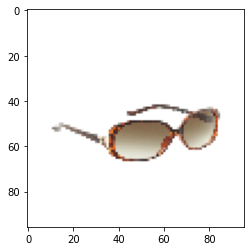

In [147]:
%matplotlib inline 
root_fashion = '../fashion_dataset/images/'

image_name = str(img_no) + '.jpg'
image_name2 = os.path.join(root_fashion, image_name)
img = cv2.imread(image_name2,3) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (96,96))
img = np.array(img, dtype=np.float32)
img = img/255

#prediction = model.predict(img)

plt.imshow(img);

In [142]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [143]:
def get_colors(image, number_of_colors):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    return rgb_colors

In [144]:
rgb = get_colors(img, 2)
rgb

[array([0.9949249 , 0.99429333, 0.9948251 ], dtype=float32),
 array([0.4091072 , 0.32429844, 0.4218722 ], dtype=float32)]

In [97]:
categories = ['top', 'skirt', 'dress']
path_top = '../deepfashionextract3/img/top/'
path_skirt = '../deepfashionextract3/img/skirt/'
path_dress = '../deepfashionextract3/img/dress/'

for i in categories:
    if prediction == 0:
        cv2.imread(path, 3)
        plt.imshow()

NameError: name 'prediction' is not defined

In [12]:
#Load data
combined = pd.read_csv('../deepfashionextract3/combined.csv', index_col=0).reset_index(drop=True)
combined.head()

,category,selected_style,image_name
0,top,Beaded,../deepfashionextract3/img/top/Beaded_Chiffon_...
1,top,Beaded,../deepfashionextract3/img/top/Beaded_Chiffon_...
2,top,Beaded,../deepfashionextract3/img/top/Beaded_Chiffon_...
3,top,Beaded,../deepfashionextract3/img/top/Beaded_Chiffon_...
4,top,Beaded,../deepfashionextract3/img/top/Beaded_Chiffon_...


In [13]:
#Find max. index no.
len(combined)

12000

In [72]:
#Random item
cross_selling1 = random.randint(0, 12000)
cross_selling2 = random.randint(0, 12000)
cross_selling3 = random.randint(0, 12000)
print(cross_selling1)
print(cross_selling2)
print(cross_selling3)

2131
2121
2702


In [73]:
#Based on minimum and maximum a random number is defined
def offer(cross):
    output = combined.iloc[cross, 2]
    first_part = output[:33]
    last_part = output[-16:]
    if first_part[-5:] == 'dress/':
        middle = output.replace('../deepfashionextract3/img/dress/','').replace(output[-16:],'')
        ident = '../deepfashionextract3/img/dress/' + middle[:-1] + '_' + last_part
    elif first_part[-5:] == 'skirt/':
        middle = output.replace('../deepfashionextract3/img/skirt/','').replace(output[-16:],'')
        ident = '../deepfashionextract3/img/skirt/' + middle[:-1] + '_' + last_part
    elif first_part[-6:-2] == 'top/':
        middle = output.replace('../deepfashionextract3/img/top/','').replace(output[-16:],'')
        ident = '../deepfashionextract3/img/top/' + middle[:-1] + '_' + last_part
    return ident

In [74]:
#Print image paths
print(offer(cross_selling1))
print(offer(cross_selling2))
print(offer(cross_selling3))

../deepfashionextract3/img/top/Abstract_Paisley_Boxy_Top_img_00000037.jpg


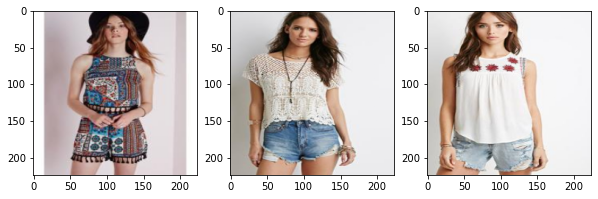

In [87]:
#Show piccture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,3,1)
ident1 = cv2.imread(offer(cross_selling1), 3)
ident1 = cv2.cvtColor(ident1, cv2.COLOR_BGR2RGB)
ident1 = cv2.resize(ident1, (224,224))
ident1 = np.array(ident1, dtype=np.float32)/255
ax1.imshow(ident1);

ax2 = fig.add_subplot(1,3,2)
ident2 = cv2.imread(offer(cross_selling2), 3)
ident2 = cv2.cvtColor(ident2, cv2.COLOR_BGR2RGB)
ident2 = cv2.resize(ident2, (224,224))
ident2 = np.array(ident2, dtype=np.float32)/255
ax2.imshow(ident2);

ax3 = fig.add_subplot(1,3,3)
ident3 = cv2.imread(offer(cross_selling3), 3)
ident3 = cv2.cvtColor(ident3, cv2.COLOR_BGR2RGB)
ident3 = cv2.resize(ident3, (224,224))
ident3 = np.array(ident3, dtype=np.float32)/255
ax3.imshow(ident3);

In [100]:
#Three most dominant colors
get_colors(ident1, 3, False)

[array([0.9056341, 0.8824864, 0.8896816], dtype=float32),
 array([0.3078322 , 0.24160016, 0.24811277], dtype=float32),
 array([0.71542  , 0.6242447, 0.6146033], dtype=float32)]

In [101]:
#Three most dominant colors
get_colors(ident2, 3, False)

[array([0.909032 , 0.9040282, 0.9044175], dtype=float32),
 array([0.3175158 , 0.25622487, 0.22858292], dtype=float32),
 array([0.67892617, 0.62859154, 0.59411407], dtype=float32)]

In [103]:
#Three most dominant colors
get_colors(ident3, 3, False)

[array([0.7896715 , 0.73356646, 0.6935267 ], dtype=float32),
 array([0.94685644, 0.9443524 , 0.9458392 ], dtype=float32),
 array([0.45818788, 0.31204343, 0.240165  ], dtype=float32)]

In [135]:
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

In [136]:
def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

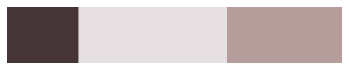

In [137]:

img = cv2.imread('../deepfashionextract3/img/top/Abstract_Paisley_Boxy_Top_img_00000037.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
clt = KMeans(n_clusters=3) #cluster number
clt.fit(img)

hist = find_histogram(clt)
bar = plot_colors2(hist, clt.cluster_centers_)

plt.axis("off")
plt.imshow(bar)
plt.show()